## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [3]:
import findspark
findspark.init()
#findspark.find()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [4]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
sc = spark.sparkContext
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df_19.show()
df_19.cache()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, SlidingTackle: in

In [5]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.show()
df_21.cache()

+---------+--------------------+-----------------+--------------------+---+----------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+----------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+---------

DataFrame[sofifa_id: int, player_url: string, short_name: string, long_name: string, age: int, dob: string, height_cm: int, weight_kg: int, nationality: string, club_name: string, league_name: string, league_rank: int, overall: int, potential: int, value_eur: int, wage_eur: int, player_positions: string, preferred_foot: string, international_reputation: int, weak_foot: int, skill_moves: int, work_rate: string, body_type: string, real_face: string, release_clause_eur: int, player_tags: string, team_position: string, team_jersey_number: int, loaned_from: string, joined: string, contract_valid_until: int, nation_position: string, nation_jersey_number: int, pace: int, shooting: int, passing: int, dribbling: int, defending: int, physic: int, gk_diving: int, gk_handling: int, gk_kicking: int, gk_reflexes: int, gk_speed: int, gk_positioning: int, player_traits: string, attacking_crossing: int, attacking_finishing: int, attacking_heading_accuracy: int, attacking_short_passing: int, attacking_v

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [6]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.cache()
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [7]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

**Getting the summary statistics:**

In [8]:
# while taking summary statistics we'll only use players that are present in both FIFA 19 and FIFA 21 databases as we are 
# performing comparison between these two years.
temp_df = df.na.drop(subset=['overall','value_eur'])
temp_df.describe().show()

+-------+-----------------+---------+------------------+--------------------+-----------+--------------------+-----------------+-----------------+--------------------+--------------------+-----------------+------------------+------------------+--------------+------------------------+------------------+------------------+--------------+---------+---------+--------+------------------+-----------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------

From the above statistics, it is seen that the average overall in 2019 is 67.86 and in 2021, it has increased to 68.63. On the other hand, the average potential has decreased from 73.05 to 72.14. In two years, the set of  players started to meet their potential while their potential to grow has decreased.

**Splitting the Dataset:**

To avoid data leakage we split the data into training and test dataset (validation) from the beginning before performing any steps related to data manipulations.

In [9]:
train_df, validation_df = df.randomSplit([0.8, 0.2], seed=2020)
train_df.cache()
validation_df.cache()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, value(M): string, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, SlidingTackle: in

**Dealing Missing Values:**

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in the desired format.

In [10]:
# checking the missing values
from pyspark.sql.functions import count, col, when
from pyspark.sql import functions as F
null_values_count = train_df.select([count(when(F.isnull(cols), cols)).alias(cols) for cols in train_df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that have impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders, not goalkeepers. It is seen that all attributes of interests have 34 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [11]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = train_df.filter(train_df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df_non_goalkeeper.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analyses.

**Missing values for potential:**

We can see from above that we only have missing values for players' potential in 2021 only. In the next step, we will analyse what type of players are having null values in 2021 for potential.

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
train_df.createOrReplaceTempView('soccer_analysis')

In [ ]:
spark.sql("""
          Select * from soccer_analysis Where Position <> 'GK' AND potential Is Null
          """).show(10)

+----+------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|  ID|        Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Sk

In [ ]:
spark.sql("""
          Select MIN(Age), MAX(Age) from soccer_analysis Where Position <> 'GK' AND potential Is Null
          """).show()

+--------+--------+
|min(Age)|max(Age)|
+--------+--------+
|      16|      41|
+--------+--------+



It is seen that players that have missing values for potential in 2021 belong to a wide range of ages. 

In [ ]:
spark.sql("""
          Select Age, MIN(`International Reputation`), MAX(`International Reputation`) from soccer_analysis 
          Where Position <> 'GK' AND potential Is Null 
          GROUP BY Age
          ORDER BY Age ASC
          """).show(30)

+---+-----------------------------+-----------------------------+
|Age|min(International Reputation)|max(International Reputation)|
+---+-----------------------------+-----------------------------+
| 16|                            1|                            1|
| 17|                            1|                            1|
| 18|                            1|                            1|
| 19|                            1|                            1|
| 20|                            1|                            1|
| 21|                            1|                            2|
| 22|                            1|                            1|
| 23|                            1|                            2|
| 24|                            1|                            2|
| 25|                            1|                            2|
| 26|                            1|                            4|
| 27|                            1|                            4|
| 28|     

Of all the ages of players, players belonging to mid-twenties to mid-thirties have a good reputation than players from other remaining age groups. So, we cannot impute players with null potential values as zero as it is not representative of the whole population. 

For this, we impute missing values based on the average potential variation from the respective age groups and calculate the potential from the potential in 2019.

**Handling of missing values in Value_2019(M) column:**

In [ ]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is Not Null AND `value(M)` Is Null
          """).show()

+------+---------------+---+--------------------+------------+--------------------+-------+---------+---------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|           Name|Age|               Photo| Nationality|                Flag|Overall|Potential|           Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|    

It is seen that although we have missing values for players value in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in the value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

The necessary operation is performed in a separate python file which we will import later.

In [ ]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+-----+---------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|   ID|           Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak

The players' values in 2019 have K to indicate 1000. We will transform this column into a numerical feature by multiplying with 1000 in our data processing. 

All the issues seen above have to be dealt with before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

### 1.2 Data Preprocessing
***

**Creating Pipelines for Data Preprocessing:**

In this stage, we create a pipeline for generating a dataframe suitable for classifying players' growth applying the necessary steps determined in the previous steps and the logic which mainly form the players' growth classification. Depending on the task, certain operations are omitted in the pipeline. For example, for classification, we will not use the ValueImputer function to impute missing values for players' monetary values in 2019 and 2021 as classification is done independently of these two columns.

Note: the modules used to generate the classification dataframe can be found in the github repository for this project.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [ ]:
!rm -rf FIFA_2019

In [12]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"
!mv "/content/FIFA_2019/encoder.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 336 (delta 192), reused 225 (delta 122), pack-reused 0
Receiving objects: 100% (336/336), 5.38 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (192/192), done.


In [13]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in the potential column for 2021
value_imputation = data_preprocessor.ValueImputer('Potential_2019', 'Potential_2021', 1)
# defining the stage that generates labels based on the potential to grow in two years
classification_target = target_generator.GrowthGenerator()

DataFrame for Classification

In [14]:
# creating a pipeline to generate a dataframe for classification
pipeline_classification = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, classification_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_classification.fit(train_df)
classification_df = pipeline_model.transform(train_df)
classification_df.cache()

The age bracket 1 has average variation of 0.004724
The age bracket 2 has average variation of -0.017822
The age bracket 3 has average variation of -0.013099
The age bracket 4 has average variation of -0.019257
The age bracket 5 has average variation of -0.027886
The age bracket 6 has average variation of 0.015873


DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): float, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sli

The above variation levels are used for imputing the test data so that the imputations are done with the same variations for both training and test data.

In [15]:
# checking the missing values after data preprocessing
classification_df.select([F.count(F.when(F.isnull(cols), cols)).alias(cols) for cols in classification_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|H

From above, we can see that the missing values in potential for 2021 has been fixed.

In [16]:
classification_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): float (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)


**Data Processing for Test Data:**

In this section, we apply all the steps that have been applied to the training data to the validation data. The only change in the processing for validation data is that we should impute the missing values for the potential column for the year 2021 with the variation that has been recorded during the training data imputation. For this, we need to import a separate script to perform the imputation for validation data.

In [17]:
!mv "/content/FIFA_2019/data_preprocessor_test.py" "/content/"

In [18]:
# creating a classification dataframe from validation data
import data_preprocessor_test

# creating a list containing the variations for different age brackets obtained from the last step
variation_list = [0.004724, -0.017822, -0.013099, -0.019257, -0.027886, 0.015873]

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in the potential column for 2021
value_imputation = data_preprocessor_test.ValueImputer(variation_list, 'Potential_2019', 'Potential_2021', 1)
# defining the stage that generates labels based on the potential to grow in two years
classification_target = target_generator.GrowthGenerator()

In [19]:
# creating a pipeline to generate a dataframe for classification
pipeline_classification = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, classification_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_classification.fit(validation_df)
classification_df2 = pipeline_model.transform(validation_df)
classification_df2.cache()

DataFrame[ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall_2019: int, Potential_2019: int, Club: string, Club Logo: string, Value_2019(M): float, wage(K): int, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: double, Height(CM): double, Weight: double, Weight(KG): double, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: int, BallControl: int, Acceleration: int, SprintSpeed: int, Agility: int, Reactions: int, Balance: int, ShotPower: int, Jumping: int, Stamina: int, Strength: int, LongShots: int, Aggression: int, Interceptions: int, Positioning: int, Vision: int, Penalties: int, Composure: int, Marking: int, StandingTackle: int, Sli

In [20]:
# checking the missing values after data preprocessing
classification_df2.select([F.count(F.when(F.isnull(cols), cols)).alias(cols) for cols in classification_df2.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|H

**Data Visualisation:**

In this part, we explore the relationship between independent variables and the target variable.

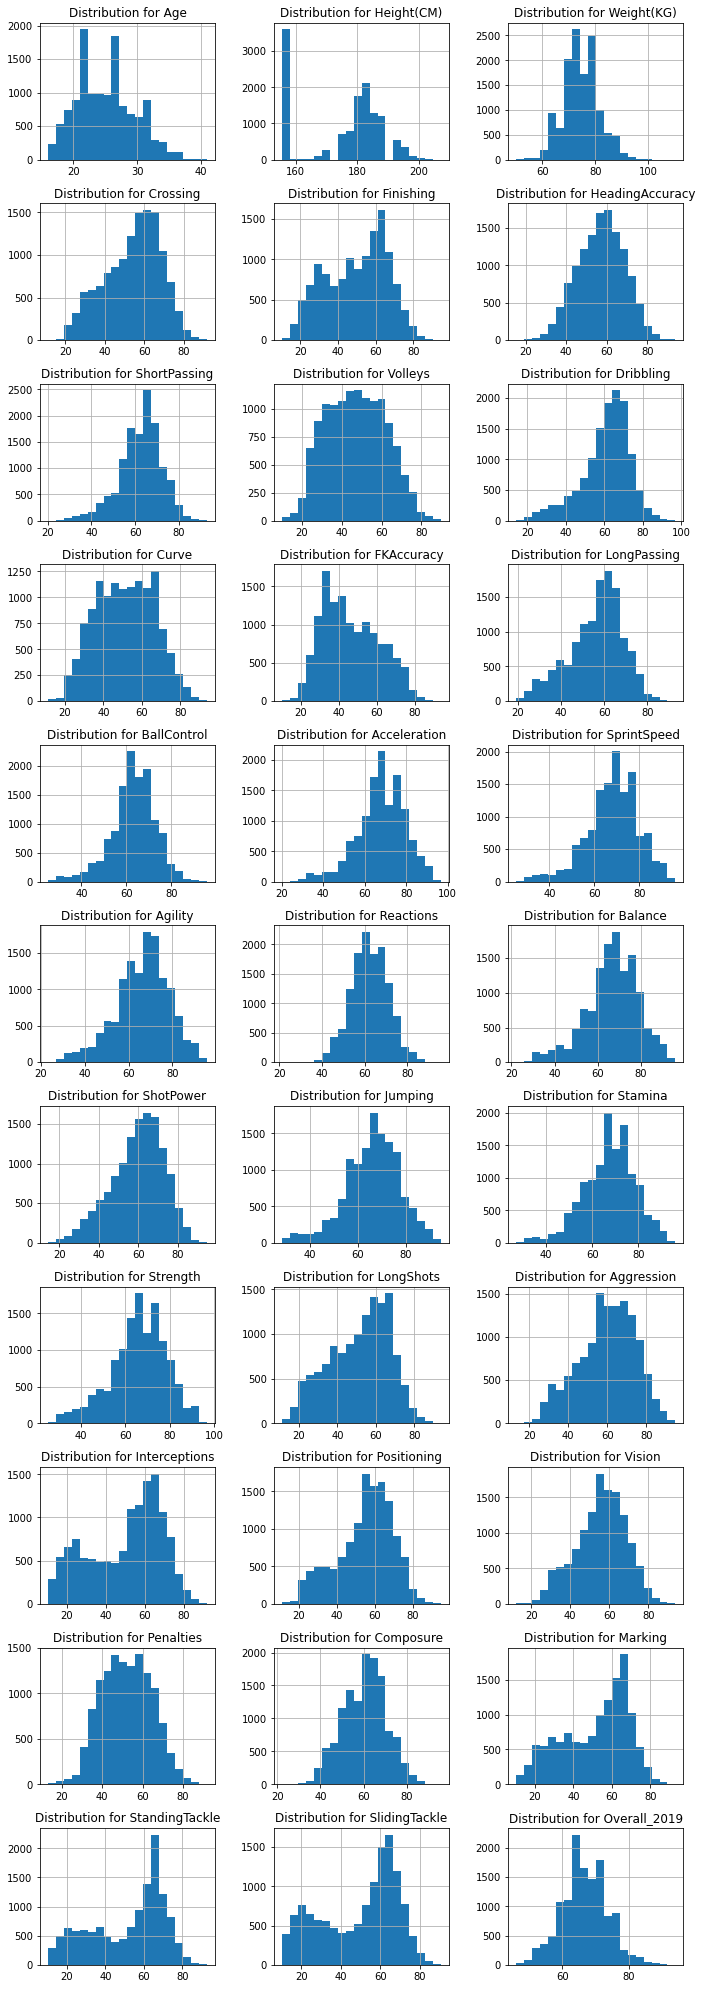

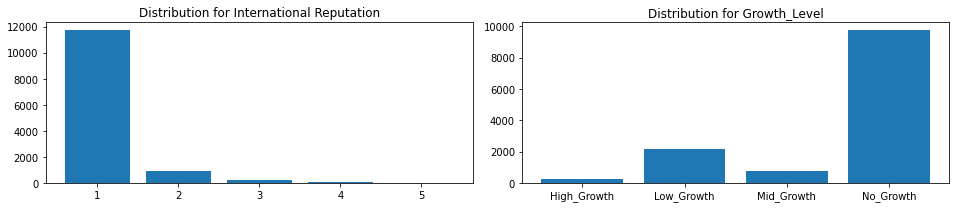

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# selecting only relevant features and dividing the features into numerical and categorical features 
features_col_numerical = ['Age', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']
features_col_categorical = ['International Reputation', 'Growth_Level']

# for numerical feature we use histograms and for cateorical we use bar charts to understand the distribution
temp_df = classification_df.toPandas()
rows = int(len(features_col_numerical)/3)+1
cols = 3

def plotter(df, features, rows, col, width, height, type):
  fig = plt.figure(figsize=(width,height))
  for i, col in enumerate(df[features]):
    ax = fig.add_subplot(rows, cols, i+1)
    if type == 'numerical':
      df.hist(column=col, ax=ax, bins=20)
      ax.set_title('Distribution for '+col)
    elif type == 'categorical':
      df2 = df.groupby(col).size().reset_index(name='count')
      #ax = df2.plot.bar(x=col, y='count')
      ax.bar(df2[col], df2['count'])
      ax.set_title('Distribution for '+col)
    

  fig.tight_layout()  
  plt.show()

# producing charts
plotter(temp_df, features_col_numerical, int(len(features_col_numerical)/3)+1, 3, 10, 30, 'numerical')
plotter(temp_df, features_col_categorical, int(len(features_col_categorical)/3)+1, 2, 20, 3, 'categorical')

From the above distribution of both numerical and categorical variables, it is seen that numerical variables are normally distributed to some level and there is a bias present in both categorical variables. For International Reputation we have many players with a low reputation of 1 and fewer players with a high reputation of 5. We can see that the number of players is in decreasing order of their reputation. Similarly, for Growth Level, No_Growth players are high and high_growth players are low. Similar to reputation, the number of players are in descending order of their growth potential.

## Part 2 - Data Manipulation & Transformation

### 2.0. Data Preparation
We try to categorise the growth of players using the attributes that determine a players' capability for a position and their status that might impact the future of a player.
***

**Preprocessor Function:**

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def steps_processor(features_col, df, weight=None):
  # encoding the target or labels
  target_encode = df.withColumn('Target', when(col('Growth_Level') == 'No_Growth', 0).when(col('Growth_Level') == 'Low_Growth', 1) \
                               .when(col('Growth_Level') == 'Mid_Growth', 2).otherwise(3))

  # creating a feature vector
  vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
  if weight is None:
    df_class = vec_assembler.transform(target_encode).select('features','Growth_Level', 'Target')
  elif weight is not None:
    df_class = vec_assembler.transform(target_encode).select('features', 'Growth_Level', 'Target', weight)

  # scaling the feature vector
  standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
  raw_data = standardscaler.fit(df_class).transform(df_class)

  return raw_data

In [22]:
features_col = ['Age', 'International Reputation', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']
train = steps_processor(features_col, classification_df)
test = steps_processor(features_col, classification_df2)

Next, we compare three baseline models and select the best baseline model for further tuning in the later step.

In [23]:
# this function expects one or all of logistic, random forest and decision tree 
def classification_model(dict_model, train, test):
  dict_models = {}
  for i in dict_model:
    model = dict_model[i].fit(train)
    predict_train = model.transform(train)
    predict_test = model.transform(test)
    dict_models[i] = [predict_train, predict_test]
  return dict_models

In [24]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier

lr = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=100)
rf = RandomForestClassifier(labelCol='Target', featuresCol='Scaled_features', numTrees=20, maxDepth=5,\
                                            impurity='gini', maxBins=32, seed=2020)
dt = DecisionTreeClassifier(labelCol='Target', featuresCol='Scaled_features', maxDepth=5, maxBins=32, impurity='gini', seed=2020)
model_list = {'Logistic Regression' : lr, 'Random Forest' : rf, 'Decision Tree' : dt}
dict_models = classification_model(model_list, train, test)

In [25]:
dict_models

{'Decision Tree': [DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]],
 'Logistic Regression': [DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]],
 'Random Forest': [DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double],
  DataFrame[features: vector, Growth_Level: string, Target: int, Scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]]}

**Model Evaluation:**

In this stage, we develop a confusion matrix to evaluate different models obtained from different classifiers.

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

def calculate_confusion_matrix(df):
  # the labels need to be in float datatype otherwise it won't work
  # creating a column that represents the target but the datatype is float
  df_float = df.select(['prediction','Target']).withColumn('label', F.col('Target').cast(FloatType()))

  # selecting only the prediction and label columns
  df_float = df_float.select(['prediction','label'])
  # casting to rdd and mapping to a tuple
  metrics = MulticlassMetrics(df_float.rdd.map(tuple))
  confusion_matrix = metrics.confusionMatrix().toArray()
  # changing the confusion matrix array datatype to int as its datatype is float
  confusion_matrix = confusion_matrix.astype('int32')
  
  return confusion_matrix, metrics

In [27]:
def calculate_performance_metrics_position(metrics):
  details = []
  for lab in 0.0,1.0,2.0,3.0:
    precision = round(metrics.precision(lab) * 100, 2)
    recall = round(metrics.recall(lab) * 100, 2)
    f1_score = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
    scores = [precision, recall, f1_score]
    details.append(scores)
  return details

**Performance Comparison:**

In this part, we create tables or dataframes to compare the performances of different classifiers.

In [28]:
# defining a function that generates comparison tables
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

def comparison_table(pos, classifiers, *args):
  # creating a new dataframe from list of classifiers
  #classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
  metrics_detail_list = []
  df_classifier = spark.createDataFrame([(l,) for l in classifiers], ['Classifier'])

  # stating conditions to select data based on player positions
  if pos == 'No_Growth':
    index = 0
    print('No Growth:')
  elif pos == 'Low_Growth':
    index = 1
    print('Low Growth:')
  elif pos == 'Mid_Growth':
    index = 2
    print('Mid Growth:')
  elif pos == 'High_Growth':
    index = 3
    print('High Growth')

  # populating the data for dataframes containing performance indicators
  for i in args:
    metrics_detail_list += [i[index]]
  
  # defining the schema of the dataframes containing performance metrics
  schema = StructType([
      StructField('Precision', FloatType(), False),
      StructField('Recall', FloatType(), False),
      StructField('F1-score', FloatType(), False)
      ])
  
  # creating a dataframe for performance metrics
  pos_df = spark.createDataFrame(metrics_detail_list, schema)

  # adding index to the dataframes to join later
  pos_df = pos_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  df_classifier = df_classifier.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  comparison_df = df_classifier.join(pos_df, pos_df.row_index == df_classifier.row_index).drop('row_index')
  
  return comparison_df

In [29]:
confusion_matrix_lr, metrics_lr = calculate_confusion_matrix(dict_models.get('Logistic Regression')[1])
performance_lr = calculate_performance_metrics_position(metrics_lr)
confusion_matrix_rf, metrics_rf = calculate_confusion_matrix(dict_models.get('Random Forest')[1])
performance_rf = calculate_performance_metrics_position(metrics_rf)
confusion_matrix_dt, metrics_dt = calculate_confusion_matrix(dict_models.get('Decision Tree')[1])
performance_dt = calculate_performance_metrics_position(metrics_dt)

In [30]:
performance_lr

[[78.62, 98.77, 87.55],
 [64.89, 16.16, 25.88],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [31]:
def show_comparison_table(classifiers, *args):
  comparison_table('No_Growth', classifiers, *[x for x in args]).show()
  comparison_table('Low_Growth', classifiers, *[x for x in args]).show()
  comparison_table('Mid_Growth', classifiers, *[x for x in args]).show() 
  comparison_table('High_Growth', classifiers, *[x for x in args]).show() 

classifiers = ('Random Forest', 'Logistic Regression', 'Decision Tree')
show_comparison_table(classifiers, performance_rf, performance_lr, performance_dt) 

No Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    81.84| 97.91|   89.15|
|Logistic Regression|    78.62| 98.77|   87.55|
|      Decision Tree|    82.99| 96.64|    89.3|
+-------------------+---------+------+--------+

Low Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|    67.15| 35.36|   46.33|
|Logistic Regression|    64.89| 16.16|   25.88|
|      Decision Tree|    62.04| 41.63|   49.83|
+-------------------+---------+------+--------+

Mid Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|      Random Forest|      0.0|   0.0|     0.0|
|Logistic Regression|      0.0|   0.0|     0.0|
|      Decision Tree|      0.0|   0.0|     0.0|
+--

In the above performance comparison, the recall of 97.91% indicates that the model can predict 97.91% of correct no_growth players. Similarly, the precision of 81.84% indicates that the model is correct 81.84% of the time when they predict a player belongs to the No_growth category. 

All three models have high recall and F1-score for the No_growth category. For the low growth category we can see some performance details whereas for the remaining two categories, all we see are zeroes for all three performance metrics. The reason for this can be attributed to the data imbalance which we saw earlier for growth categories.


**Class Balancing:**

To balance the dataset, we use SMOTE upsampling/ downsampling which we developed for upsampling and downsampling multiple classes. 

In [ ]:
# only for colab
!mv "/content/FIFA_2019/smote_multiclass_sampling.py" "/content/"

In [ ]:
# selecting only scaled features and target to up/ downsample
train = train.select(['Scaled_features', 'Target'])
test = test.select(['Scaled_features', 'Target'])

In [ ]:
# rough
train.show(5)

+--------------------+------------+------+--------------------+
|            features|Growth_Level|Target|     Scaled_features|
+--------------------+------------+------+--------------------+
|[34.0,4.0,173.736...|   No_Growth|     0|[7.47606018751398...|
|[34.0,1.0,188.976...|   No_Growth|     0|[7.47606018751398...|
|[32.0,1.0,185.928...|   No_Growth|     0|[7.03629194118963...|
|[34.0,3.0,179.832...|   No_Growth|     0|[7.47606018751398...|
|[33.0,5.0,188.976...|   No_Growth|     0|[7.25617606435181...|
+--------------------+------------+------+--------------------+
only showing top 5 rows



The rate of upsampling and downsampling for the respective majority and minority classes.

Downsample Class 0: 80
Upsample Class 1: 300
Upsample Class 2: 900
Upsample Class 3: 3000

In [ ]:
import smote_multiclass_sampling as smt
obj = smt.SMOTEMultiClassBalancer(spark_context=sc, target='Target', minority_class=1, majority_class=0, upsample_percentage=300, downsample_percentage=80)
train = obj.transform(train)

Is there any more minority classes? Type Yes or No. yes
Enter minority class:2
Enter upsample percentage:900
Is there any more minority classes? Type Yes or No. yes
Enter minority class:3
Enter upsample percentage:3000
Is there any more minority classes? Type Yes or No. no


In [ ]:
train.groupby('Target').agg({'Scaled_features':'count'}).show()

+------+----------------------+
|Target|count(Scaled_features)|
+------+----------------------+
|     0|                  7767|
|     1|                  8632|
|     3|                  8339|
|     2|                  7390|
+------+----------------------+



In [ ]:
test.groupby('Target').agg({'Scaled_features':'count'}).show()

+------+----------------------+
|Target|count(Scaled_features)|
+------+----------------------+
|     1|                   441|
|     3|                   105|
|     2|                   269|
|     0|                  3980|
+------+----------------------+



For checking SMOTE effects, we select the decision tree.

In [ ]:
# using decision tree for classification
dt = DecisionTreeClassifier(labelCol='Target', featuresCol='Scaled_features', maxDepth=5, maxBins=32, weightCol='Weight', impurity='gini', seed=2020)
model_list = {'Decision Tree' : dt}
dict_models = classification_model(model_list, train, test)

# obtaining confusion matrix using validation set 
confusion_matrix_dt, metrics_dt = calculate_confusion_matrix(dict_models.get('Decision Tree')[1])
performance_dt = calculate_performance_metrics_position(metrics_dt)

# showing the comparison table
print('Performance for decision tree:')
classifier = ('Decision Tree',)
show_comparison_table(classifier, performance_dt) 

Performance for decision tree:
No Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    87.03| 71.55|   78.53|
+-------------+---------+------+--------+

Low Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    48.89| 29.28|   36.62|
+-------------+---------+------+--------+

Mid Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|     10.0| 19.16|   13.14|
+-------------+---------+------+--------+

High Growth
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|     5.23| 46.03|    9.39|
+-------------+---------+------+--------+



From SMOTE up/downsampling, we improved the decision tree model to classify high growth and mid growth from zero to around 10 at the expense of missing out on classifying no growth and low growth players by some points.

**Checking the Performance for the Training Set:**

In [ ]:
# obtaining confusion matrix for three classifiers
confusion_matrix_dt, metrics_dt = calculate_confusion_matrix(dict_models.get('Decision Tree')[0])
performance_dt = calculate_performance_metrics_position(metrics_dt)

In [ ]:
# showing the comparison table
print('Performance for training data:')
classifier = ('Decision Tree',)
show_comparison_table(classifier, performance_dt) 

Performance for training data:
No Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    44.45| 79.93|   57.13|
+-------------+---------+------+--------+

Low Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    41.03| 44.54|   42.72|
+-------------+---------+------+--------+

Mid Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    52.86|  9.39|   15.95|
+-------------+---------+------+--------+

High Growth
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    50.51| 45.29|   47.76|
+-------------+---------+------+--------+



It seems that using synthetic samples in the training process caused our model to have high variance in general as the performance in the validation set is very low for all groups except for the "No Growth" category compared to the training set performance. Having more data would help in reducing the generalising error and make a more accurate prediction on the validation set. Despite this, we try other techniques such as assigning weights to classes and feature engineering to see if we can improve the performance.

**Adjusing Weights:**

In this part, we create a new column called weight in which priority is assigned based on their presence in the dataset such that high-frequency classes are given low value and vice-versa. First, we determine class weights for different classes. Then, map each row containing a label to its class weight. To do that we create a list containing tuples of class and its weight using the items method. Then we create a single iterable from a series of iterables generated from unpacking the results from the items method using the chain method. Then we create literal columns from the values from the iterable, which is then converted to MapType. Using the new custom map, we map the label to its corresponding weight.

In [32]:
import numpy as np
from itertools import chain
from pyspark.sql.functions import lit, create_map, col

def weight_allocator(df):
  # getting a list containing the count for each label
  target_count = df.select('Growth_Level').groupby('Growth_Level').count().collect()
  # creating a list of unique labels
  unique_target = [x['Growth_Level'] for x in target_count]
  # getting the total number of samples in the dataset
  total_samples = sum([x['count'] for x in target_count])
  # storing the total number of labels
  label_count = len(target_count)
  # creating a list to store bin count for each label
  bin_count = [x['count'] for x in target_count]

  # generating the class weights based on the class frequency in the data. This is similar to how weights are calculated in scikit-learn
  class_weights = {key: value  for key, value in zip(unique_target, total_samples / (label_count * np.array(bin_count)))}
  print(class_weights)

  custom_map = create_map([lit(x) for x in chain(*class_weights.items())])
  df = df.withColumn('Weight', custom_map.getItem(col('Growth_Level')))
  return df

In [33]:
# getting the training dataset containing weights
train= steps_processor(features_col, weight_allocator(classification_df), 'Weight')

{'High_Growth': 12.013940520446097, 'Mid_Growth': 4.373139377537212, 'No_Growth': 0.33108800327835264, 'Low_Growth': 1.4975671918443003}


In [34]:
train.show(5)

+--------------------+------------+------+-------------------+--------------------+
|            features|Growth_Level|Target|             Weight|     Scaled_features|
+--------------------+------------+------+-------------------+--------------------+
|[34.0,4.0,173.736...|   No_Growth|     0|0.33108800327835264|[7.47606018751398...|
|[34.0,1.0,188.976...|   No_Growth|     0|0.33108800327835264|[7.47606018751398...|
|[32.0,1.0,185.928...|   No_Growth|     0|0.33108800327835264|[7.03629194118963...|
|[34.0,3.0,179.832...|   No_Growth|     0|0.33108800327835264|[7.47606018751398...|
|[33.0,5.0,188.976...|   No_Growth|     0|0.33108800327835264|[7.25617606435181...|
+--------------------+------------+------+-------------------+--------------------+
only showing top 5 rows



In [35]:
# using decision tree for classification
dt = DecisionTreeClassifier(labelCol='Target', featuresCol='Scaled_features', maxDepth=5, maxBins=32, weightCol='Weight', impurity='gini', seed=2020)
model_list = {'Decision Tree' : dt}
dict_models = classification_model(model_list, train, test)

# obtaining confusion matrix 
confusion_matrix_dt, metrics_dt = calculate_confusion_matrix(dict_models.get('Decision Tree')[1])
performance_dt = calculate_performance_metrics_position(metrics_dt)

# showing the comparison table
print('Performance for decision tree:')
classifier = ('Decision Tree',)
show_comparison_table(classifier, performance_dt) 

Performance for decision tree:
No Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    87.58| 58.67|   70.27|
+-------------+---------+------+--------+

Low Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|    61.65| 15.59|   24.89|
+-------------+---------+------+--------+

Mid Growth:
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|     6.81| 36.53|   11.48|
+-------------+---------+------+--------+

High Growth
+-------------+---------+------+--------+
|   Classifier|Precision|Recall|F1-score|
+-------------+---------+------+--------+
|Decision Tree|     6.02| 50.79|   10.76|
+-------------+---------+------+--------+



Classifying samples based on their importance was able to improve the performance compared to the original one, but the overall performance is low compared to the SMOTE performance.

**Using Embedded Method:**

We enable Lasso regression in Logistic regression to see if reducing the value of unimportant coefficients to zero improves the performance or not.

In [36]:
lr = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=100, elasticNetParam=1, regParam=0.8, weightCol='Weight')
model_list = {'Logistic Regression' : lr}
dict_models = classification_model(model_list, train, test)

# obtaining confusion matrix 
confusion_matrix_lr, metrics_lr = calculate_confusion_matrix(dict_models.get('Logistic Regression')[1])
performance_lr = calculate_performance_metrics_position(metrics_lr)

# showing the comparison table
print('Performance for logistic regression:')
classifier = ('Logistic Regression',)
show_comparison_table(classifier, performance_lr) 

Performance for logistic regression:
No Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|      0.0|   0.0|     0.0|
+-------------------+---------+------+--------+

Low Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|      0.0|   0.0|     0.0|
+-------------------+---------+------+--------+

Mid Growth:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|      0.0|   0.0|     0.0|
+-------------------+---------+------+--------+

High Growth
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|     1.97| 100.0|    3.87|
+

Using embedded methods to reduce features performed worse than without penalising the best fit data. 

The conclusion from this analysis is that due to the low amount of data for groups other than no growth category, we are not able to develop a robust model that can predict the growth level of a player. 